# Suporting code 

This little demo, used for the presentation 
```
L. Jacques, "The importance of phase in complex compressive sensing"
AI for Signal and Image Processing, (virtual) Paris-Saclay, September 10th, 2021
```
mplements the algorithm proposed in: 
```
Oppenheim, Alan V., and Jae S. Lim. "The importance of phase in signals." Proceedings of the IEEE 69.5 (1981): 529-541.
```
to recover an image $f$ from it spectral phases $\mathcal F[f]/|\mathcal F[f]|$. 

The algorithm is an alternate projection onto convex sets (POCS) and the two convex sets are: 
* the set of images defined on the support of $\Omega$ of $f$, restricted to $\tilde \Omega \supset \Omega$, for instance $\tilde \Omega$ is two times bigger than $\Omega$ in every direction; 
* the set of images whose spectral phase match the one of $f$.

Dependence(s):
* SciPy

Last update: 9/9/2021

In [10]:
import numpy as np
from scipy import interpolate
from scipy.sparse.linalg import LinearOperator
from scipy.fftpack import fft2, ifft2


#import scikit.image.data.load

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

#from scipy.sparse.linalg import LinearOperator
#from scipy.sparse import spdiags
import spgl1

# Initialize random number generators
np.random.seed(43273289)
#%matplotlib inline

# Directory for saving images
img_dir = './'

Let's load and display an image.

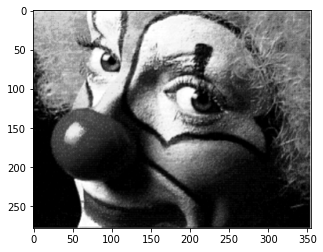

In [11]:
from skimage import data, io, filters

image = np.double(io.imread('./clown.png',as_gray=True))
nx, ny = image.shape
plt.imshow(image, cmap='gray')
plt.show()

Let's extend it, from $\Omega$ to $\tilde \Omega$.

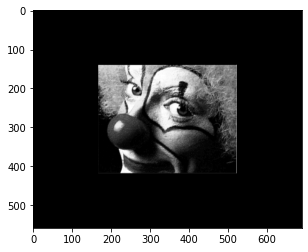

In [3]:
[ny, nx] = image.shape
x = np.pad(image,[(140,140), (167,167)], mode='constant')
plt.imshow(x, cmap='gray')
plt.show()

Let's define some operators

In [4]:
# numerical error constant: 10*np.finfo(np.float32).eps
epsilon = 100*np.finfo(np.float32).eps 

# complex sign operator, keep the "phasor"
signc = lambda x: x / (np.absolute(x) + (x == 0)*epsilon) 

# First the mask of where is the image
Omega = np.pad(np.ones(image.shape),[(140,140), (167,167)], mode='constant') == 1
# Note: \tilde\Omega is actually the full domain after padding

# Second, a projector on image supported on Omega
def proj_supp(im, omg):
    return im*omg

# Third, projection on images having the same spectral phase than z
# Projector on the set of images whose spectral phase matches the one of "z" 
def proj_consist(im, z):
    return ifft2(np.abs(fft2(im))*z)   

Let's run the algorithm

In [5]:
# the observations
z0 = signc(fft2(x))

# the algorithm
#xk = np.random.randn(x.shape[0],x.shape[1])
x_init = np.ones(x.shape)

xk = x_init
nb_iter = 100
for k in range(nb_iter):
    oxk = xk
    xk = proj_supp(xk, Omega)
    xk = proj_consist(xk, z0)   
    rel_err = np.linalg.norm(oxk-xk)/np.linalg.norm(oxk)
    if rel_err < 1e-5:
        break

rec_im = np.real(xk[Omega]).reshape(ny,nx)   
snr_im = 20*np.log10(1/np.linalg.norm((image/np.linalg.norm(image)) - (rec_im/np.linalg.norm(rec_im))))
print(f"Break at iteration {k}, relative error: {rel_err}, snr: {snr_im}")
    

Break at iteration 99, relative error: 0.000705762308090408, snr: 19.571831473954116


Showing the result

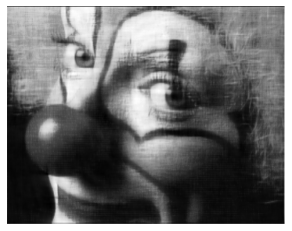

In [6]:
rec_im = np.real(xk[Omega]).reshape(ny,nx)   
plt.imshow(rec_im, cmap='gray', vmin = rec_im.min(), vmax=rec_im.max())
plt.axis('off')
plt.savefig(img_dir + f"rec_img_iter{k}.pdf", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

# A more systematic analysis

Let's now study the success of the recovery in function of the oversampling ratio, that is, the ration between the true number of phase-only measurements we made about the image (that is the number of samples in the FT of the zero padded image) and the number of pixels of the original image.

Note: This part can take some time to run ... ☕☕☕

In [7]:
[ny, nx] = image.shape

pow_seq = np.linspace(-1,0.5,16)
ny_pad = np.round(ny*(2**pow_seq - 0.5))
nx_pad = np.round(nx*(2**pow_seq - 0.5))
ny_pad = ny_pad.astype(int).copy()
nx_pad = nx_pad.astype(int).copy()
nb_pad = nx_pad.size
nb_pocs_iter = 1000
snr_im = np.zeros(nb_pad)
    
for s in range(nb_pad):
    print(f"Running padding #{s}, Oversampling: {(nx+2*nx_pad[s])*(ny+2*ny_pad[s])/(nx*ny)}, ...")
    # padding the image (the oversampling procedure)
    x = np.pad(image,[(ny_pad[s],ny_pad[s]), (nx_pad[s],nx_pad[s])], mode='constant')
    
    # setting the correspoinding mask
    Omega = np.pad(np.ones(image.shape),[(ny_pad[s],ny_pad[s]), (nx_pad[s],nx_pad[s])], mode='constant') == 1

    # the observations
    z0 = signc(fft2(x))

    # the algorithm
    x_init = np.ones(x.shape)

    xk = x_init
    for k in range(nb_pocs_iter):
        oxk = xk
        xk = proj_supp(xk, Omega)
        xk = proj_consist(xk, z0)   
        rel_err = np.linalg.norm(oxk-xk)/np.linalg.norm(oxk)
        if rel_err < 1e-5:
            break

    rec_im = np.real(xk[Omega]).reshape(ny,nx)   
    snr_im[s] = 20*np.log10(1/np.linalg.norm((image/np.linalg.norm(image)) - (rec_im/np.linalg.norm(rec_im))))
    
    print(f"... -> SNR: {snr_im[s]} dB")


Running padding #0, Oversampling: 1.0, ...
... -> SNR: 2.9865752565077153 dB
Running padding #1, Oversampling: 1.1504509068801296, ...
... -> SNR: 6.102767307080965 dB
Running padding #2, Oversampling: 1.3196879116425169, ...
... -> SNR: 8.139033366061344 dB
Running padding #3, Oversampling: 1.5143783564697537, ...
... -> SNR: 9.272550335469328 dB
Running padding #4, Oversampling: 1.7393251595906374, ...
... -> SNR: 11.31746830386713 dB
Running padding #5, Oversampling: 2.008126456581214, ...
... -> SNR: 20.94194134037883 dB
Running padding #6, Oversampling: 2.3047725200121594, ...
... -> SNR: 29.339205502247662 dB
Running padding #7, Oversampling: 2.6426588306819334, ...
... -> SNR: 34.04335503524952 dB
Running padding #8, Oversampling: 3.035728037288479, ...
... -> SNR: 37.47332724715335 dB
Running padding #9, Oversampling: 3.479927044280069, ...
... -> SNR: 39.84600520762979 dB
Running padding #10, Oversampling: 4.005633802816901, ...
... -> SNR: 41.44322815194716 dB
Running padding

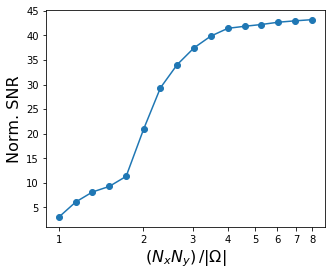

In [9]:
# let's compute an oversampling ration between the true number of measurements (due to the zero padding) and the initial image size
ovs_ratio = (nx+2*nx_pad)*(ny+2*ny_pad)/(nx*ny)

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(ovs_ratio, snr_im, 'o-')
ax.set_xlabel('$(N_x N_y)\,/ |\Omega|$', fontsize=16)
ax.set_xscale('log')
ax.set_xticks([1, 2, 3, 4, 5, 6,7,8])
ax.set_xticklabels([1, 2, 3, 4, 5, 6,7,8])
ax.set_ylabel('Norm. SNR',fontsize=16)
fig.savefig('OppRecIm_SNR_vs_ovsp.pdf', bbox_inches='tight', pad_inches=0, transparent=True)